### MNIST With Tensorflow and Tensor Board Visualization: Deep

In [1]:
import tensorflow as tf
from collections import namedtuple
from collections import deque
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
_ = plt.gray();

In [2]:
class MNIST(object):
    image = namedtuple("image", "data,normalized_data,w,h,size")
    label = namedtuple("label", "label,encoded,size")
    
    def __init__(self):
        self.train_image = self.read_image("train-images-idx3-ubyte")
        self.test_image = self.read_image("t10k-images-idx3-ubyte")
        self.train_label = self.read_label("train-labels-idx1-ubyte")
        self.test_label = self.read_label("t10k-labels-idx1-ubyte")
    
    def as_int(self, bytes):
        r = 0
        for b in bytes:
            r = (r << 8) | ord(b)
        return r
    
    def read_label(self, filename):
        with open(filename, "rb") as f:
            self.as_int(f.read(4)) # magic number
            size = self.as_int(f.read(4))
            digits = np.array(map(lambda x: ord(x), f.read(-1)))
            encoded = np.zeros([size, 10], dtype=np.float32)
            encoded[np.arange(size),digits] = 1
        return self.label(digits, encoded, size)
    
    def read_image(self, filename):
        with open(filename, "rb") as f:
            self.as_int(f.read(4)) # magic number
            size = self.as_int(f.read(4))
            w = self.as_int(f.read(4))
            h = self.as_int(f.read(4))
            data = np.array(map(lambda x: ord(x), f.read(-1)), dtype=np.float32).reshape(-1, w*h)
            norm = (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-5)
        return self.image(data=data, normalized_data=norm, w=w, h=h, size=size)
    
    def _range_max(self, row, length):
        queue = deque()
        output = [0 for _ in xrange(len(row) - length + 1)]
        length -= 1
        for j, e in enumerate(row):
            while(len(queue) != 0 and queue[0][0] <= e):
                queue.popleft()
            queue.appendleft((e, j))
            if j < length:
                continue
            while(queue[-1][1] < (j - length)):
                queue.pop()
            
            output[j - length] = queue[-1][0]
            
        return output
        
    def _grid_max(self, arr2d, grid=(4, 4)):
        temp = np.array([self._range_max(arr1d, length=grid[0]) for arr1d in arr2d]).T
        return np.array([self._range_max(arr1d, length=grid[1]) for arr1d in temp]).T
    
    def augment_feature(self, data, grid=(5, 5)):
        """
        data is a 784xS size 2d array
        each row is reshaped 28x28 image
        lets calculate max in each grid
        """
        imsize = 28
        data_cube = data.reshape(data.shape[0], imsize, imsize)
        return np.array([self._grid_max(matrix, grid) for matrix in data_cube])

mnist = MNIST()

In [3]:
def next_batch(X, y, size):
    select = np.random.choice(X.shape[0], size)
    return (X[select,:], y[select,:])

In [7]:
tf.reset_default_graph()

def variable_summaries(var, name):
    with tf.name_scope('summaries/' + name):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        

def dense_layer(name, input_dim, output_dim):
    with tf.variable_scope(name):
        W = tf.get_variable("W", shape=[input_dim, output_dim], 
                            dtype=tf.float64, initializer=tf.glorot_uniform_initializer())
        b = tf.get_variable("b", shape=[output_dim], dtype=tf.float64, initializer=tf.zeros_initializer())
        variable_summaries(W, name + "/weights")
        variable_summaries(b, name + "/biases")
        
    return W, b


def activation_layer(name, X, W, b, function=tf.nn.relu):
    with tf.variable_scope(name):
        y = tf.matmul(X, W, name="WX_plus_b") + b
        if function is not None:
            y_ = function(y, name="activation")
        else:
            y_ = y # identity
        variable_summaries(y_, name + "/activation")
        
    return y_


def dropout_layer(name, X, keep_prob):
    with tf.variable_scope(name):
        dropout = tf.nn.dropout(X, keep_prob=keep_prob, name="dropout")
    
    return dropout

#=======================================================================#

input_dim = 784
X = tf.placeholder(tf.float64, [None, input_dim])
keep_prob = tf.placeholder(dtype=tf.float64)

dropout1 = dropout_layer("Layer1", X, keep_prob)

L1_size = 512
W1, b1 = dense_layer("Layer1", input_dim, L1_size)
y1 = activation_layer("Layer1", dropout1, W1, b1)

L2_size = 256
W2, b2 = dense_layer("Layer2", L1_size, L2_size)
y2 = activation_layer("Layer2", y1, W2, b2)

L3_size = 64
W3, b3 = dense_layer("Layer3", L2_size, L3_size)
y3 = activation_layer("Layer3", y2, W3, b3)

output_dim = 10
W4, b4 = dense_layer("Layer4", L3_size, output_dim)
y4 = activation_layer("Layer4", y3, W4, b4)

y_ = tf.placeholder(tf.float64, [None, output_dim])

with tf.variable_scope("Loss"):
    cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y4), name="CrossEntropyLoss")

train_step = tf.train.GradientDescentOptimizer(learning_rate=0.04).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y4, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar('cross_entropy', cross_entropy)
tf.summary.scalar('accuracy', accuracy)

merged = tf.summary.merge_all()

X_train, X_test, y_train, y_test = train_test_split(mnist.train_image.normalized_data, 
                                                    mnist.train_label.encoded, test_size=0.05)

with tf.Session() as sess:
    train_writer = tf.summary.FileWriter('train', sess.graph)
    tf.global_variables_initializer().run()
    batch_size = 100
    iterations = 20000
    step_size = 10000
    steps = batch_size * iterations / step_size
    for i in range(iterations):
        batch_xs, batch_ys = next_batch(X_train, y_train, batch_size)
        sess.run(train_step, feed_dict={X: batch_xs, y_: batch_ys, keep_prob:0.6})
        
        if (batch_size * i % step_size) == 0:
            batch_xs, batch_ys = X_test, y_test
            summary, acc_, loss_ = sess.run([merged, accuracy, cross_entropy], 
                                            feed_dict={X: batch_xs, y_: batch_ys, keep_prob:1.0})
            train_writer.add_summary(summary, global_step=i * batch_size / step_size)
            print "Step %d/%d, accuracy: %0.4f, loss=%0.6f" % (batch_size * i / step_size, steps, acc_, loss_)
        
    # Final accuracy on trained model
    predictions, accuracy_ = sess.run(
        [correct_prediction, accuracy], 
        feed_dict={X: mnist.test_image.normalized_data, y_: mnist.test_label.encoded, keep_prob: 1.0})
    
    print("Accuracy on test set: %0.4f" % accuracy_)

Step 0/200, accuracy: 0.1677, loss=2.328176
Step 1/200, accuracy: 0.8450, loss=0.553453
Step 2/200, accuracy: 0.9047, loss=0.335571
Step 3/200, accuracy: 0.9183, loss=0.297216
Step 4/200, accuracy: 0.9293, loss=0.254889
Step 5/200, accuracy: 0.9320, loss=0.238650
Step 6/200, accuracy: 0.9330, loss=0.229732
Step 7/200, accuracy: 0.9403, loss=0.208746
Step 8/200, accuracy: 0.9400, loss=0.211886
Step 9/200, accuracy: 0.9440, loss=0.192773
Step 10/200, accuracy: 0.9460, loss=0.183091
Step 11/200, accuracy: 0.9507, loss=0.180362
Step 12/200, accuracy: 0.9507, loss=0.176781
Step 13/200, accuracy: 0.9530, loss=0.173635
Step 14/200, accuracy: 0.9557, loss=0.168483
Step 15/200, accuracy: 0.9537, loss=0.171493
Step 16/200, accuracy: 0.9610, loss=0.165146
Step 17/200, accuracy: 0.9597, loss=0.152185
Step 18/200, accuracy: 0.9623, loss=0.139979
Step 19/200, accuracy: 0.9600, loss=0.136212
Step 20/200, accuracy: 0.9653, loss=0.141245
Step 21/200, accuracy: 0.9620, loss=0.144431
Step 22/200, accurac

Step 181/200, accuracy: 0.9830, loss=0.076265
Step 182/200, accuracy: 0.9830, loss=0.077607
Step 183/200, accuracy: 0.9807, loss=0.076633
Step 184/200, accuracy: 0.9843, loss=0.072680
Step 185/200, accuracy: 0.9823, loss=0.081301
Step 186/200, accuracy: 0.9823, loss=0.077613
Step 187/200, accuracy: 0.9827, loss=0.076536
Step 188/200, accuracy: 0.9827, loss=0.079168
Step 189/200, accuracy: 0.9807, loss=0.084000
Step 190/200, accuracy: 0.9807, loss=0.082709
Step 191/200, accuracy: 0.9817, loss=0.083290
Step 192/200, accuracy: 0.9817, loss=0.081658
Step 193/200, accuracy: 0.9800, loss=0.083565
Step 194/200, accuracy: 0.9817, loss=0.087800
Step 195/200, accuracy: 0.9817, loss=0.085859
Step 196/200, accuracy: 0.9820, loss=0.084782
Step 197/200, accuracy: 0.9830, loss=0.076238
Step 198/200, accuracy: 0.9847, loss=0.073593
Step 199/200, accuracy: 0.9837, loss=0.080331
Accuracy on test set: 0.9818


In [15]:
missclassified_images = mnist.test_image.data[~predictions]
print (missclassified_images.shape)

(182, 784)


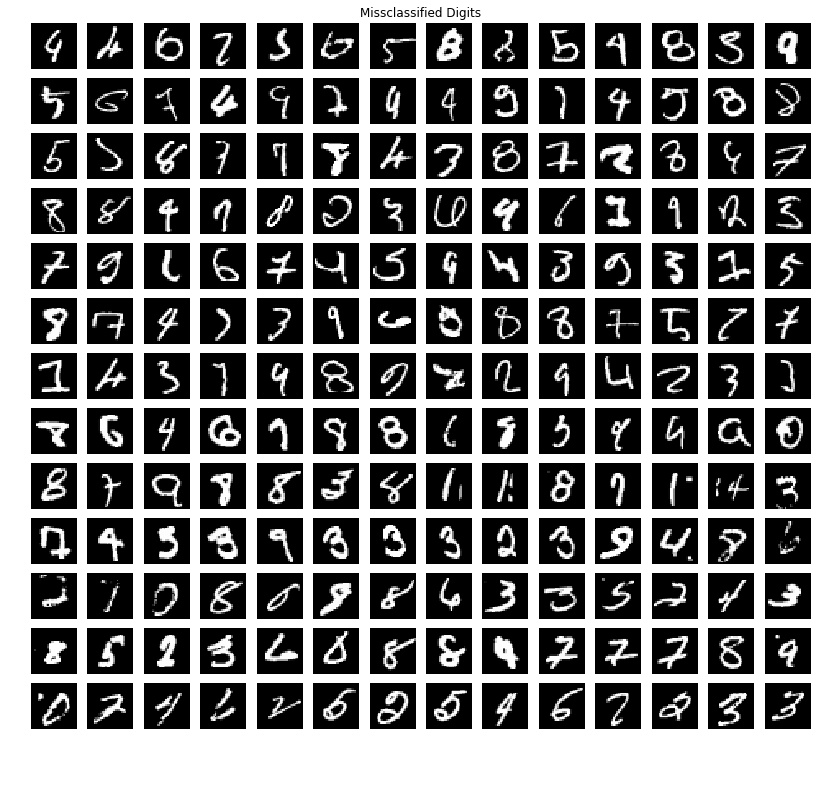

In [22]:
fig = plt.figure(figsize=(14,14))
plt.title("Missclassified Digits")
plt.axis("off")
for i, row in enumerate(missclassified_images):
    fig.add_subplot(14, 14, i+1).axis("off")
    plt.imshow(row.reshape(28, 28))